# Neural Network Text Classifier
We explore a few variants of NN classifiers using word embeddings:
<ul>
<li>Perceptron</li>
<li>Perceptron with One-hot vectors</li>
<li>Perceptron with pretrained embeddings</li>
<li>Multilayer perceptron with pretrained embeddings</li>
</ul>
Adapted from code at https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py

## Import modules

Disregard the `Futurewarning` message.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.layers import Embedding

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:496: FutureWarn

### Set parameters

In [2]:
max_num_words = 5000
maxlen = 80    # max sentence length
batch_size = 32
embedding_dims = 50
hidden_dims = 250
epochs = 2

## Loading data

Wec need a temporary fix for problems with libraries on the server.

In [3]:
# Fix for:
#    ValueError: Object arrays cannot be loaded when allow_pickle=False
# save np.load
import numpy as np
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_num_words, index_from=0)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


Pad sequences to `maxlen`

In [5]:
from keras.preprocessing import sequence
x_train = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


Show one example

In [6]:
x_train[0]

array([   1,   11,   19,   13,   40,  527,  970, 1619, 1382,   62,  455,
       4465,   63, 3938,    1,  170,   33,  253,    2,   22,   97,   40,
        835,  109,   47,  667,    2,    6,   32,  477,  281,    2,  147,
          1,  169,  109,  164,    2,  333,  382,   36,    1,  169, 4533,
       1108,   14,  543,   35,   10,  444,    1,  189,   47,   13,    3,
        144, 2022,   16,   11,   19,    1, 1917, 4610,  466,    1,   19,
         68,   84,    9,   13,   40,  527,   35,   73,   12,   10, 1244,
          1,   19,   14], dtype=int32)

Recover the words from the word index:

In [7]:
word_index = imdb.get_word_index()

In [8]:
index_words = {i:w for w,i in word_index.items()}

Show a review:

In [9]:
' '.join([index_words[i] for i in x_train[2]])

'the this has to be one of the worst films of the and when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had'

## Perceptron

In [10]:
model = Sequential()

We start off with an efficient embedding layer which maps
our vocab indices into embedding_dims dimensions

In [11]:
model.add(Embedding(max_num_words,
                    embedding_dims,
                    embeddings_initializer='random_uniform',
                    input_length=maxlen))
model.add(Flatten())

We ad a hidden layer with a single unit output, and squash it with a sigmoid:

In [12]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

Compile the model:

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show the model

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 50)            250000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4001      
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 254,001
Trainable params: 254,001
Non-trainable params: 0
_________________________________________________________________


### Plot model

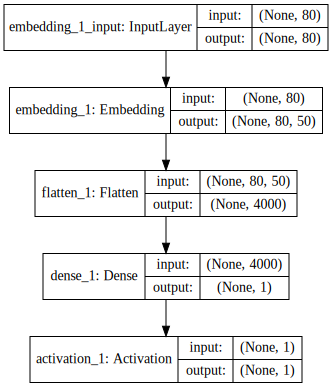

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Training

In [16]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 5s 205us/step - loss: 0.5358 - acc: 0.7235 - val_loss: 0.4289 - val_acc: 0.7981
Epoch 2/2
25000/25000 [==============================] - 5s 199us/step - loss: 0.3355 - acc: 0.8569 - val_loss: 0.4369 - val_acc: 0.7946


### Testing
We already used test data during training to check accuracy on held out data, so this step isn't really necessary.

However, let's see how to do it after the training.

In [17]:
predictions = model.predict(x_test)

In [18]:
predictions

array([[0.08132765],
       [0.8642474 ],
       [0.75995857],
       ...,
       [0.02312185],
       [0.27390894],
       [0.71558404]], dtype=float32)

In [19]:
predictions.round()

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

See the correct results

In [20]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

Compare predictions with the correct results

In [21]:
errors = y_test - predictions.round().flatten()
errors

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [22]:
len(errors[errors==0])

19865

In [23]:
len(errors[errors==0])/len(errors)

0.7946

### Evaluation

In [24]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7946


Plot the accuracy through the epochs

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

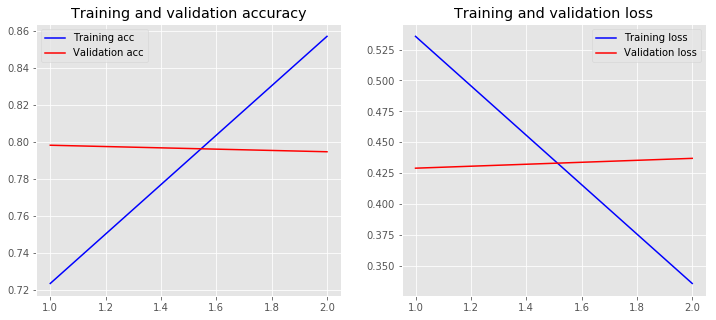

In [26]:
plot_history(history)

## Exploring the fine-tuned embeddings

In [27]:
model.layers

In [28]:
embeddings = model.get_weights()[0]
embeddings.shape

(5000, 50)

In [29]:
embeddings[0]

array([-0.00521712,  0.05838636,  0.01510611,  0.02983965,  0.02778213,
        0.04816814,  0.03309373, -0.03875129,  0.0164423 ,  0.06317428,
        0.00259347, -0.03730792, -0.00538006,  0.02275871,  0.03427103,
        0.02958457, -0.0194081 , -0.00982942,  0.00441831,  0.00384971,
       -0.01585448, -0.03901654,  0.01449844,  0.01197905, -0.02679993,
       -0.02171998,  0.02036016, -0.03072585,  0.04076178,  0.05502331,
       -0.01688004,  0.02687482, -0.02898526, -0.04819415,  0.02483886,
       -0.01914527, -0.03194577, -0.0655401 , -0.02336057, -0.03897459,
        0.0343235 , -0.04082248, -0.04640425,  0.07149742,  0.00243088,
       -0.00700005, -0.04163829,  0.00201613, -0.02621148, -0.01668194],
      dtype=float32)

In [30]:
embeddings[0].dot(embeddings[1])

0.0007849041

### Evaluation

In [31]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7946


### Explore
Experiment yourself, by increasing the number of epochs, adding layers, etc

For example, add an hidden layer and a dropout:

## Perceptron with one-hot representations

In [32]:
model_one_hot = Sequential()

This is NOT a real embedding layer, it is just a trick 
to convert words into one-hot representations.

Note that the embeddinfs are not trained, thet never changes during training.

In [33]:
model_one_hot.add(Embedding(max_num_words,
                    max_num_words,
                    embeddings_initializer='identity',
                    input_length=maxlen,
                    trainable=False))  # do not train the embeddings

model_one_hot.add(Flatten())

We project onto a single unit output layer, and squash it with a sigmoid:

In [34]:
model_one_hot.add(Dense(1))
model_one_hot.add(Activation('sigmoid'))

Compile the model:

In [35]:
model_one_hot.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show model

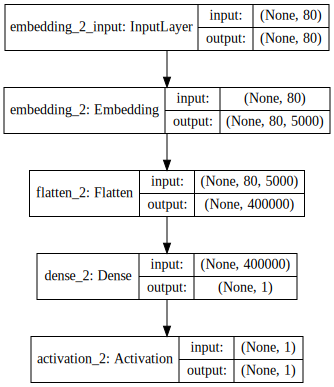

In [36]:
SVG(model_to_dot(model_one_hot, show_shapes=True).create(prog='dot', format='svg'))

### Train the model

In [37]:
model_one_hot.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 40s 2ms/step - loss: 0.6564 - acc: 0.6348 - val_loss: 0.6282 - val_acc: 0.6725
Epoch 2/2
25000/25000 [==============================] - 39s 2ms/step - loss: 0.4595 - acc: 0.9072 - val_loss: 0.5984 - val_acc: 0.6921


### Evaluate

In [38]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7946


## Perceptron with pretrained embeddings

Load GloVe embeddings

In [39]:
import glove
glove_embeddings = glove.Glove.load_stanford('data/glove.6B/glove.6B.50d.txt')

Create a matrix with embeddings for words in the index

In [88]:
num_words = min(max_num_words, len(word_index) + 1) # +1 for padding

# Initialize with random weights
embedding_dims = glove_embeddings.word_vectors.shape[1]
word_embeddings = np.random.uniform(-0.2, 0.2, (num_words, embedding_dims))

for word, i in word_index.items():
    if i >= num_words:
        continue
    idx = glove_embeddings.dictionary.get(word)
    if idx is not None:
        # words not found in embeddings will have random weights
        word_embeddings[i] = glove_embeddings.word_vectors[idx]

### Perceptron Model

In [41]:
model = Sequential()
model.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1], 
                    weights=[word_embeddings], 
                    input_length=maxlen, 
                    trainable=True))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) # second layer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Train the model

In [42]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    batch_size=10)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 14s 563us/step - loss: 0.5908 - acc: 0.6920 - val_loss: 0.5280 - val_acc: 0.7400
Epoch 2/5
25000/25000 [==============================] - 14s 560us/step - loss: 0.3966 - acc: 0.8237 - val_loss: 0.5810 - val_acc: 0.7469
Epoch 3/5
25000/25000 [==============================] - 14s 561us/step - loss: 0.2755 - acc: 0.8871 - val_loss: 0.5519 - val_acc: 0.7664
Epoch 4/5
25000/25000 [==============================] - 14s 558us/step - loss: 0.1645 - acc: 0.9433 - val_loss: 0.6372 - val_acc: 0.7599
Epoch 5/5
25000/25000 [==============================] - 14s 558us/step - loss: 0.0801 - acc: 0.9809 - val_loss: 0.7329 - val_acc: 0.7563


### Evaluate

Training Accuracy: 0.9979
Testing Accuracy:  0.7563


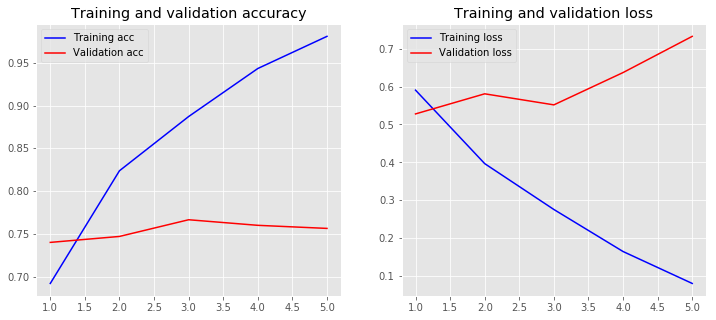

In [43]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Multi (2) Layer Perceptron

We use GloVe embeddings in the first layer.

In [94]:
model = Sequential()
model.add(Embedding(word_embeddings.shape[0],
                    word_embeddings.shape[1], 
                    weights=[word_embeddings], 
                    input_length=maxlen, 
                    trainable=True))

We add a convolution layer.

The next figure illustrates how such a convolution works. It starts by taking a pool of input vectors of the given `pool_size`. These vectors are reduced to a single vector, in the case of `MaxPooling1D` by taking the largest value along each dimension.

<img src='image/MaxPooling1D.jpg'>

In [90]:
from keras.layers import MaxPooling1D

model.add(MaxPooling1D(pool_size=2, strides=1))
model.add(Flatten())
model.add(Dense(10, activation='relu'))   # first layer
model.add(Dense(1, activation='sigmoid')) # second layer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

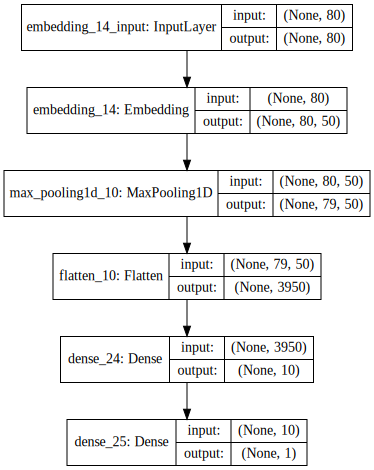

In [91]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Train the model

This will take longer, ...

In [92]:
history = model.fit(x_train, y_train,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    batch_size=10)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 20s 802us/step - loss: 0.6870 - acc: 0.5254 - val_loss: 0.6359 - val_acc: 0.6727
Epoch 2/5
25000/25000 [==============================] - 20s 786us/step - loss: 0.5245 - acc: 0.7598 - val_loss: 0.4842 - val_acc: 0.7808
Epoch 3/5
25000/25000 [==============================] - 20s 786us/step - loss: 0.3802 - acc: 0.8459 - val_loss: 0.4667 - val_acc: 0.7892
Epoch 4/5
25000/25000 [==============================] - 20s 785us/step - loss: 0.2828 - acc: 0.8974 - val_loss: 0.5189 - val_acc: 0.7859
Epoch 5/5
25000/25000 [==============================] - 20s 785us/step - loss: 0.1977 - acc: 0.9378 - val_loss: 0.6026 - val_acc: 0.7724


### Evaluate

Training Accuracy: 0.9657
Testing Accuracy:  0.7724


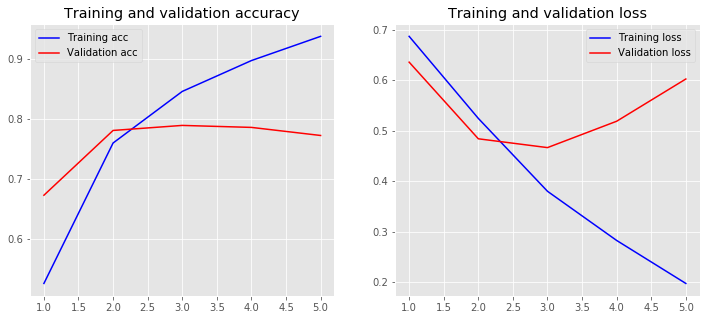

In [93]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)